# Research

by Joshua Isaacson and Hannah Isaacson 

For our Fall 2017 SICE@IU undergraduate research project, *A Sentiment-Based Long-Short Equity Strategy*.

## Components

1. Universe Selection
2. Alphalens Factor Analysis
3. Rebalancing
4. Portfolio
5. Pipeline

##  Universe Selection

This component covers our process of defining the trading universe for which the algorithm operates.

### Imports 

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from quantopian.pipeline.filters import Q1500US
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.filters.fundamentals import IsPrimaryShare
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import CustomFactor, Returns
from quantopian.pipeline.classifiers.fundamentals import Sector
from quantopian.pipeline.data.sentdex import sentiment_free
from quantopian.pipeline.factors import SimpleMovingAverage
from time import time
import alphalens as al

### Universe

WHY DID WE CHOOSE THIS
WHAT EQUITIES ARE IN IT

In [98]:
universe = Q1500US()

## Factor Analysis

We want to test to see how good our alpha factors are at predicting relative price movements. A wide range of factors that are independent of each other yield a better ranking scheme.

The factors we are going to evaluate are:
* bearish_intensity
* bullish_intensity
* sentiment_signal
* sentiment moving average (10, 20, 30, 50, 80 day)
    * simple and exponential

### Fields in PsychSignal Dataset

In [99]:
def print_fields(dataset):
    print "Dataset: %s\n" % dataset.__name__
    print "Fields:"
    for field in list(dataset.columns):
        print "%s - %s" % (field.name, field.dtype)
    print "\n"

for data in (stocktwits,):
    print_fields(data)

Dataset: stocktwits

Fields:
bullish_intensity - float64
symbol - object
bull_bear_msg_ratio - float64
source - object
bear_scored_messages - float64
asof_date - datetime64[ns]
bull_minus_bear - float64
bearish_intensity - float64
bull_scored_messages - float64
total_scanned_messages - float64




### Fields in Sentdex Sentiment Analysis Dataset

In [100]:
def print_fields(dataset):
    print "Dataset: %s\n" % dataset.__name__
    print "Fields:"
    for field in list(dataset.columns):
        print "%s - %s" % (field.name, field.dtype)
    print "\n"

for data in (sentiment_free,):
    print_fields(data)

Dataset: sentiment_free

Fields:
symbol - object
asof_date - datetime64[ns]
sentiment_signal - float64




### Sentiment Signal Moving Averages

Simple Moving Averages

In [101]:
sma_10 = SimpleMovingAverage(inputs=[sentiment_free.sentiment_signal], window_length=10, mask=universe)
sma_20 = SimpleMovingAverage(inputs=[sentiment_free.sentiment_signal], window_length=20, mask=universe)
sma_30 = SimpleMovingAverage(inputs=[sentiment_free.sentiment_signal], window_length=30, mask=universe)
sma_50 = SimpleMovingAverage(inputs=[sentiment_free.sentiment_signal], window_length=50, mask=universe)
sma_80 = SimpleMovingAverage(inputs=[sentiment_free.sentiment_signal], window_length=80, mask=universe)

### Sector Codes

In [102]:
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,
}

### Getting Data

In [103]:
pipe = Pipeline()

pipe.add(stocktwits.bearish_intensity.latest, 'bearish_intensity')
pipe.add(stocktwits.bullish_intensity.latest, 'bullish_intensity')
pipe.add(sentiment_free.sentiment_signal.latest, 'sentiment_signal')
pipe.add(sma_10, 'sma_10')
pipe.add(sma_20, 'sma_20')
pipe.add(sma_30, 'sma_30')
pipe.add(sma_50, 'sma_50')
pipe.add(sma_80, 'sma_80')
pipe.add(Sector(), 'Sector')

pipe.set_screen(universe)

start_timer = time()
results = run_pipeline(pipe, '2015-01-01', '2016-01-01')
end_timer = time()

print("Time to run pipeline %.2f secs" % (end_timer - start_timer))

Time to run pipeline 45.19 secs


### Dealing with NaN Values

In [104]:
adjusted_dataset = results.interpolate()
adjusted_dataset.head()
#len(adjusted_dataset)

Sector  bearish_intensity  \
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])      101               0.00   
                          Equity(24 [AAPL])     311               1.82   
                          Equity(41 [ARCB])     310               0.91   
                          Equity(62 [ABT])      206               0.00   
                          Equity(67 [ADSK])     311               1.70   

                                             bullish_intensity  \
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])                1.20   
                          Equity(24 [AAPL])               1.46   
                          Equity(41 [ARCB])               0.73   
                          Equity(62 [ABT])                0.00   
                          Equity(67 [ADSK])               0.00   

                                             sentiment_signal  sma_10  sma_20  \
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])                2.0     2.8   3.600   
                          Equity(24 [AAPL])               2.0     1.8   0.200   
                          Equity(41 [ARCB])               1.5    -0.2  -0.375   
                          Equity(62 [ABT])                1.0    -2.2  -0.950   
                          Equity(67 [ADSK])               6.0     6.0   6.000   

                                               sma_30  sma_50  sma_80  
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])   4.266667    4.26  2.7375  
                          Equity(24 [AAPL])  0.800000    0.80  0.8750  
                          Equity(41 [ARCB])  0.416667    0.88  1.3250  
                          Equity(62 [ABT])   0.033333    0.96  1.7750  
                          Equity(67 [ADSK])  5.933333    4.56  4.2500

### Filtering for Unique Equities

# TODO

* first name the equity column, the drop duplicates based on it
* Alphalens tearsheet for:
    * bearish_intensity
    * bullish_intensity
    * sentiment_signal
    * sentiment moving averages
* choose factors
* choose how to distribute long and short
* backtest
* analyze portfolio
* repeat backtests

### Factor Output from Pipeline

All factors are from the pipeline's output, adjusted to interpolate the NaNs.

In [105]:
bearish_intensity_factor = adjusted_dataset['bearish_intensity']
print(bearish_intensity_factor.head())

2015-01-02 00:00:00+00:00  Equity(2 [ARNC])     0.00
                           Equity(24 [AAPL])    1.82
                           Equity(41 [ARCB])    0.91
                           Equity(62 [ABT])     0.00
                           Equity(67 [ADSK])    1.70
Name: bearish_intensity, dtype: float64


In [106]:
bullish_intensity_factor = adjusted_dataset['bullish_intensity']
print(bullish_intensity_factor.head())

2015-01-02 00:00:00+00:00  Equity(2 [ARNC])     1.20
                           Equity(24 [AAPL])    1.46
                           Equity(41 [ARCB])    0.73
                           Equity(62 [ABT])     0.00
                           Equity(67 [ADSK])    0.00
Name: bullish_intensity, dtype: float64


In [107]:
sentiment_signal_factor = adjusted_dataset['sentiment_signal']
print(sentiment_signal_factor.head())

2015-01-02 00:00:00+00:00  Equity(2 [ARNC])     2.0
                           Equity(24 [AAPL])    2.0
                           Equity(41 [ARCB])    1.5
                           Equity(62 [ABT])     1.0
                           Equity(67 [ADSK])    6.0
Name: sentiment_signal, dtype: float64


In [108]:
sma_10_factor = adjusted_dataset['sma_10']
print(sma_10_factor.head())

2015-01-02 00:00:00+00:00  Equity(2 [ARNC])     2.8
                           Equity(24 [AAPL])    1.8
                           Equity(41 [ARCB])   -0.2
                           Equity(62 [ABT])    -2.2
                           Equity(67 [ADSK])    6.0
Name: sma_10, dtype: float64


In [109]:
sma_20_factor = adjusted_dataset['sma_20']
print(sma_20_factor.head())

2015-01-02 00:00:00+00:00  Equity(2 [ARNC])     3.600
                           Equity(24 [AAPL])    0.200
                           Equity(41 [ARCB])   -0.375
                           Equity(62 [ABT])    -0.950
                           Equity(67 [ADSK])    6.000
Name: sma_20, dtype: float64


In [110]:
sma_30_factor = adjusted_dataset['sma_30']
print(sma_30_factor.head())

2015-01-02 00:00:00+00:00  Equity(2 [ARNC])     4.266667
                           Equity(24 [AAPL])    0.800000
                           Equity(41 [ARCB])    0.416667
                           Equity(62 [ABT])     0.033333
                           Equity(67 [ADSK])    5.933333
Name: sma_30, dtype: float64


In [111]:
sma_50_factor = adjusted_dataset['sma_50']
print(sma_50_factor.head())

2015-01-02 00:00:00+00:00  Equity(2 [ARNC])     4.26
                           Equity(24 [AAPL])    0.80
                           Equity(41 [ARCB])    0.88
                           Equity(62 [ABT])     0.96
                           Equity(67 [ADSK])    4.56
Name: sma_50, dtype: float64


In [112]:
sma_80_factor = adjusted_dataset['sma_80']
print(sma_80_factor.head())

2015-01-02 00:00:00+00:00  Equity(2 [ARNC])     2.7375
                           Equity(24 [AAPL])    0.8750
                           Equity(41 [ARCB])    1.3250
                           Equity(62 [ABT])     1.7750
                           Equity(67 [ADSK])    4.2500
Name: sma_80, dtype: float64


We also want to see equity performance broken down by sector.

In [113]:
sectors = adjusted_dataset['Sector']

Grab the pricing data for the unique equities in our pipeline.

In [114]:
asset_list = adjusted_dataset.index.levels[1].unique()
prices = get_pricing(asset_list, start_date='2015-01-01', end_date='2016-01-01', fields='price')
len(asset_list)

1736

In [115]:
prices.head()

Equity(2 [ARNC])  Equity(24 [AAPL])  \
2015-01-02 00:00:00+00:00            15.717            107.469   
2015-01-05 00:00:00+00:00            14.817            104.470   
2015-01-06 00:00:00+00:00            14.906            104.451   
2015-01-07 00:00:00+00:00            15.302            105.945   
2015-01-08 00:00:00+00:00            15.757            109.996   

                           Equity(41 [ARCB])  Equity(53 [ABMD])  \
2015-01-02 00:00:00+00:00             45.513              37.30   
2015-01-05 00:00:00+00:00             44.839              37.09   
2015-01-06 00:00:00+00:00             42.805              36.13   
2015-01-07 00:00:00+00:00             41.734              37.28   
2015-01-08 00:00:00+00:00             42.716              38.96   

                           Equity(62 [ABT])  Equity(67 [ADSK])  \
2015-01-02 00:00:00+00:00            43.977              59.53   
2015-01-05 00:00:00+00:00            43.997              58.66   
2015-01-06 00:00:00+00:00            43.478              57.50   
2015-01-07 00:00:00+00:00            43.840              57.37   
2015-01-08 00:00:00+00:00            44.731              58.80   

                           Equity(76 [TAP])  Equity(110 [ACXM])  \
2015-01-02 00:00:00+00:00            72.300              19.605   
2015-01-05 00:00:00+00:00            71.889              19.425   
2015-01-06 00:00:00+00:00            71.527              19.080   
2015-01-07 00:00:00+00:00            73.807              19.330   
2015-01-08 00:00:00+00:00            76.088              19.790   

                           Equity(114 [ADBE])  Equity(122 [ADI])  \
2015-01-02 00:00:00+00:00               72.33             54.041   
2015-01-05 00:00:00+00:00               71.99             53.058   
2015-01-06 00:00:00+00:00               70.52             51.812   
2015-01-07 00:00:00+00:00               71.12             52.357   
2015-01-08 00:00:00+00:00               72.91             53.281   

                                   ...           Equity(49203 [GCI])  \
2015-01-02 00:00:00+00:00          ...                           NaN   
2015-01-05 00:00:00+00:00          ...                           NaN   
2015-01-06 00:00:00+00:00          ...                           NaN   
2015-01-07 00:00:00+00:00          ...                           NaN   
2015-01-08 00:00:00+00:00          ...                           NaN   

                           Equity(49209 [BXLT])  Equity(49210 [CC])  \
2015-01-02 00:00:00+00:00                   NaN                 NaN   
2015-01-05 00:00:00+00:00                   NaN                 NaN   
2015-01-06 00:00:00+00:00                   NaN                 NaN   
2015-01-07 00:00:00+00:00                   NaN                 NaN   
2015-01-08 00:00:00+00:00                   NaN                 NaN   

                           Equity(49213 [ENR])  Equity(49229 [KHC])  \
2015-01-02 00:00:00+00:00                  NaN                  NaN   
2015-01-05 00:00:00+00:00                  NaN                  NaN   
2015-01-06 00:00:00+00:00                  NaN                  NaN   
2015-01-07 00:00:00+00:00                  NaN                  NaN   
2015-01-08 00:00:00+00:00                  NaN                  NaN   

                           Equity(49242 [PYPL])  Equity(49279 [BUFF])  \
2015-01-02 00:00:00+00:00                   NaN                   NaN   
2015-01-05 00:00:00+00:00                   NaN                   NaN   
2015-01-06 00:00:00+00:00                   NaN                   NaN   
2015-01-07 00:00:00+00:00                   NaN                   NaN   
2015-01-08 00:00:00+00:00                   NaN                   NaN   

                           Equity(49496 [FDC])  Equity(49506 [HPE])  \
2015-01-02 00:00:00+00:00                  NaN                  NaN   
2015-01-05 00:00:00+00:00                  NaN                  NaN   
2015-01-06 00:00:00+00:00                  NaN                  NaN   
2015-01-

## Alphalens Factor Analysis

Now that we have created the pipeline to filter and gather the equities, we will use the Alphalens tool provided by Quantopian to analyze the alpha factors that we want to test. Ultimately, we will use this tool and the metrics it gives us to understand each alpha factor's inherent ability to predict future price. We are looking for a high Alpha, a Beta close to 0, a high Sharpe Ratio, and a high Spearman Correlation.

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -3.000000 -1.000000 -1.872212  0.660200  83909  23.283931
2               -1.571429  0.242857 -0.980192  0.205201  64865  17.999406
3               -1.000000  1.500000  0.057146  0.560288  68018  18.874333
4               -0.233333  2.983333  1.389361  0.582642  71931  19.960152
5                1.300000  6.000000  3.524240  1.139444  71650  19.882178

Returns Analysis


1      5      10
Ann. alpha                                    -0.006 -0.009 -0.006
beta                                          -0.009 -0.010 -0.018
Mean Period Wise Return Top Quantile (bps)    -1.083 -4.344 -5.047
Mean Period Wise Return Bottom Quantile (bps) -0.040 -0.476 -0.253
Mean Period Wise Spread (bps)                 -1.069 -0.774 -0.447

Information Analysis


1      5      10
IC Mean      0.000  0.002  0.002
IC Std.      0.039  0.036  0.034
t-stat(IC)   0.086  0.909  0.928
p-value(IC)  0.931  0.364  0.354
IC Skew     -0.191  0.017 -0.148
IC Kurtosis -0.326 -0.549 -0.346
Ann. IR      0.088  0.928  0.947

Turnover Analysis


1      5     10
Quantile 1 Mean Turnover   0.054  0.214  0.359
Quantile 2 Mean Turnover   0.139  0.377  0.521
Quantile 3 Mean Turnover   0.130  0.418  0.551
Quantile 4 Mean Turnover   0.133  0.424  0.557
Quantile 5 Mean Turnover   0.063  0.240  0.395

1      5    10
Mean Factor Rank Autocorrelation  0.992  0.907  0.77

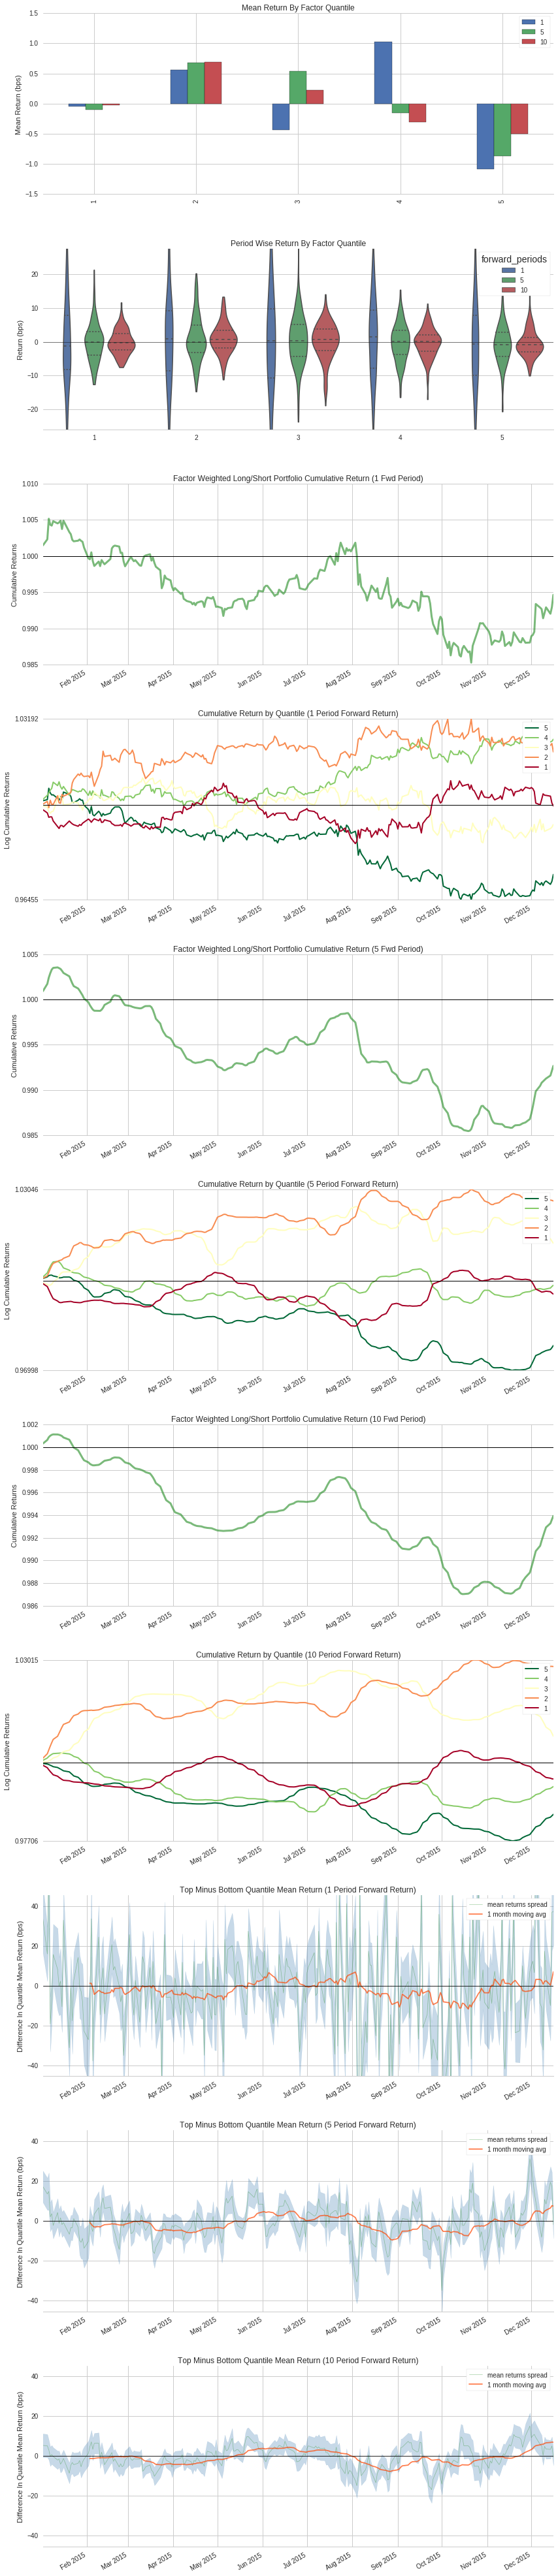

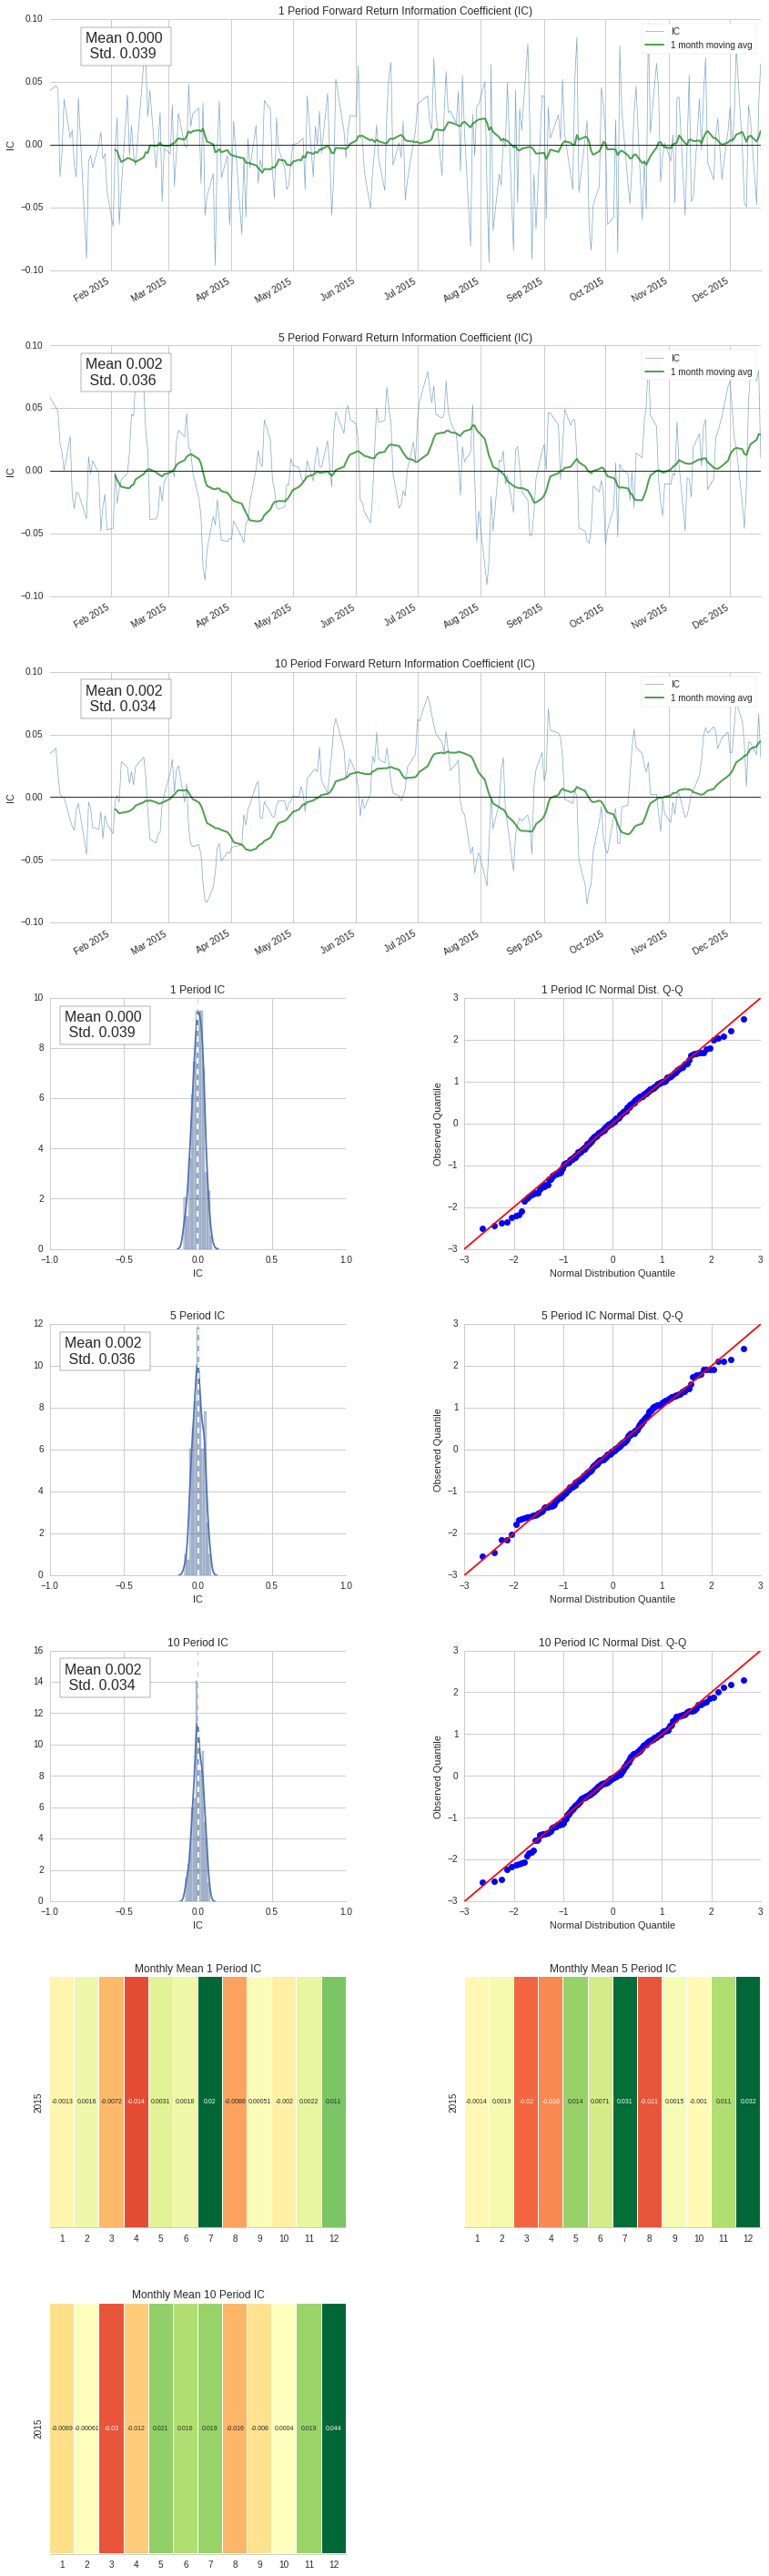

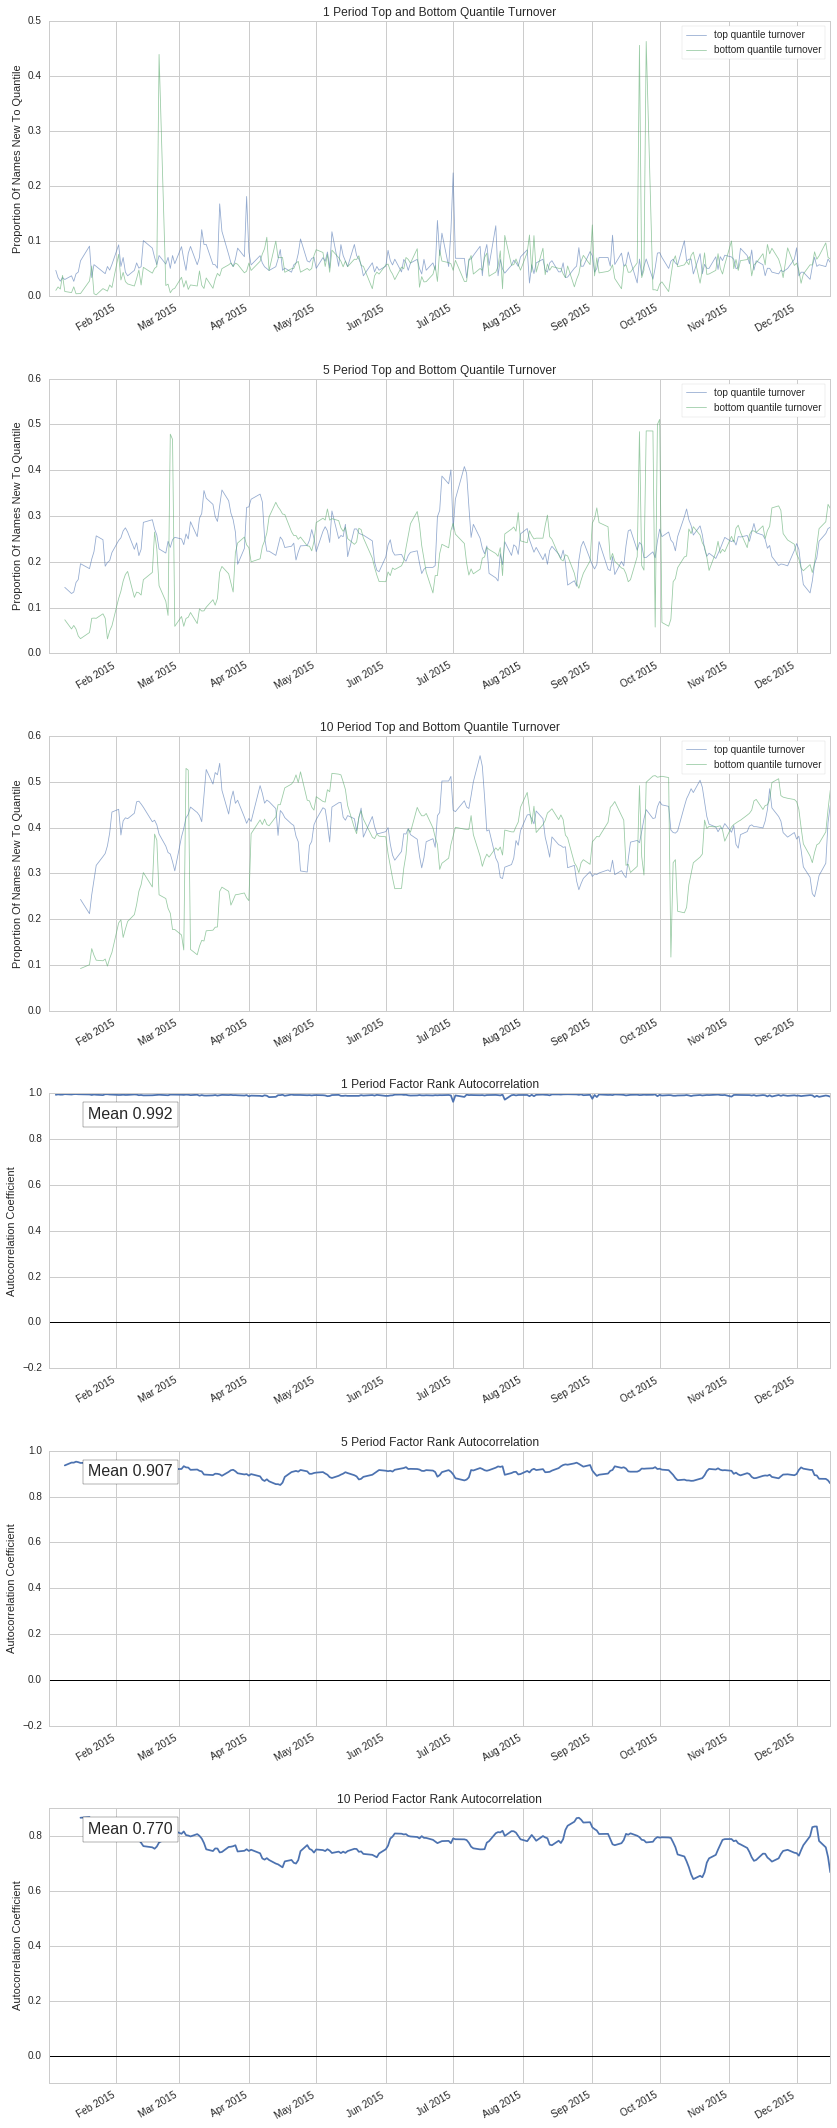

In [121]:
sma_10_factor_data = al.utils.get_clean_factor_and_forward_returns(
                                                            factor=sma_10_factor,
                                                            prices=prices,
                                                            groupby=sectors,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            periods=(1, 5, 10))
sma_10_factor_data.head()
al.tears.create_full_tear_sheet(sma_10_factor_data)

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -3.000000 -1.000000 -1.822973  0.575035  77914  21.620377
2               -1.490909  0.200000 -0.933458  0.261496  67509  18.733090
3               -1.000000  1.650000  0.138525  0.551094  71068  19.720678
4               -0.127273  2.807143  1.403484  0.546172  71969  19.970697
5                1.312500  6.000000  3.307349  1.053331  71913  19.955158

Returns Analysis


1      5      10
Ann. alpha                                    -0.002 -0.005 -0.003
beta                                          -0.012 -0.014 -0.013
Mean Period Wise Return Top Quantile (bps)     0.204  0.827  2.519
Mean Period Wise Return Bottom Quantile (bps) -0.081 -0.950 -0.312
Mean Period Wise Spread (bps)                  0.062  0.220  0.205

Information Analysis


1      5      10
IC Mean      0.002  0.005  0.004
IC Std.      0.039  0.038  0.036
t-stat(IC)   0.748  1.960  1.747
p-value(IC)  0.455  0.051  0.082
IC Skew     -0.155  0.052 -0.048
IC Kurtosis -0.397 -0.440 -0.598
Ann. IR      0.763  2.000  1.782

Turnover Analysis


1      5     10
Quantile 1 Mean Turnover   0.037  0.155  0.272
Quantile 2 Mean Turnover   0.081  0.303  0.449
Quantile 3 Mean Turnover   0.081  0.317  0.480
Quantile 4 Mean Turnover   0.085  0.323  0.481
Quantile 5 Mean Turnover   0.040  0.163  0.287

1      5     10
Mean Factor Rank Autocorrelation  0.997  0.959  0.881

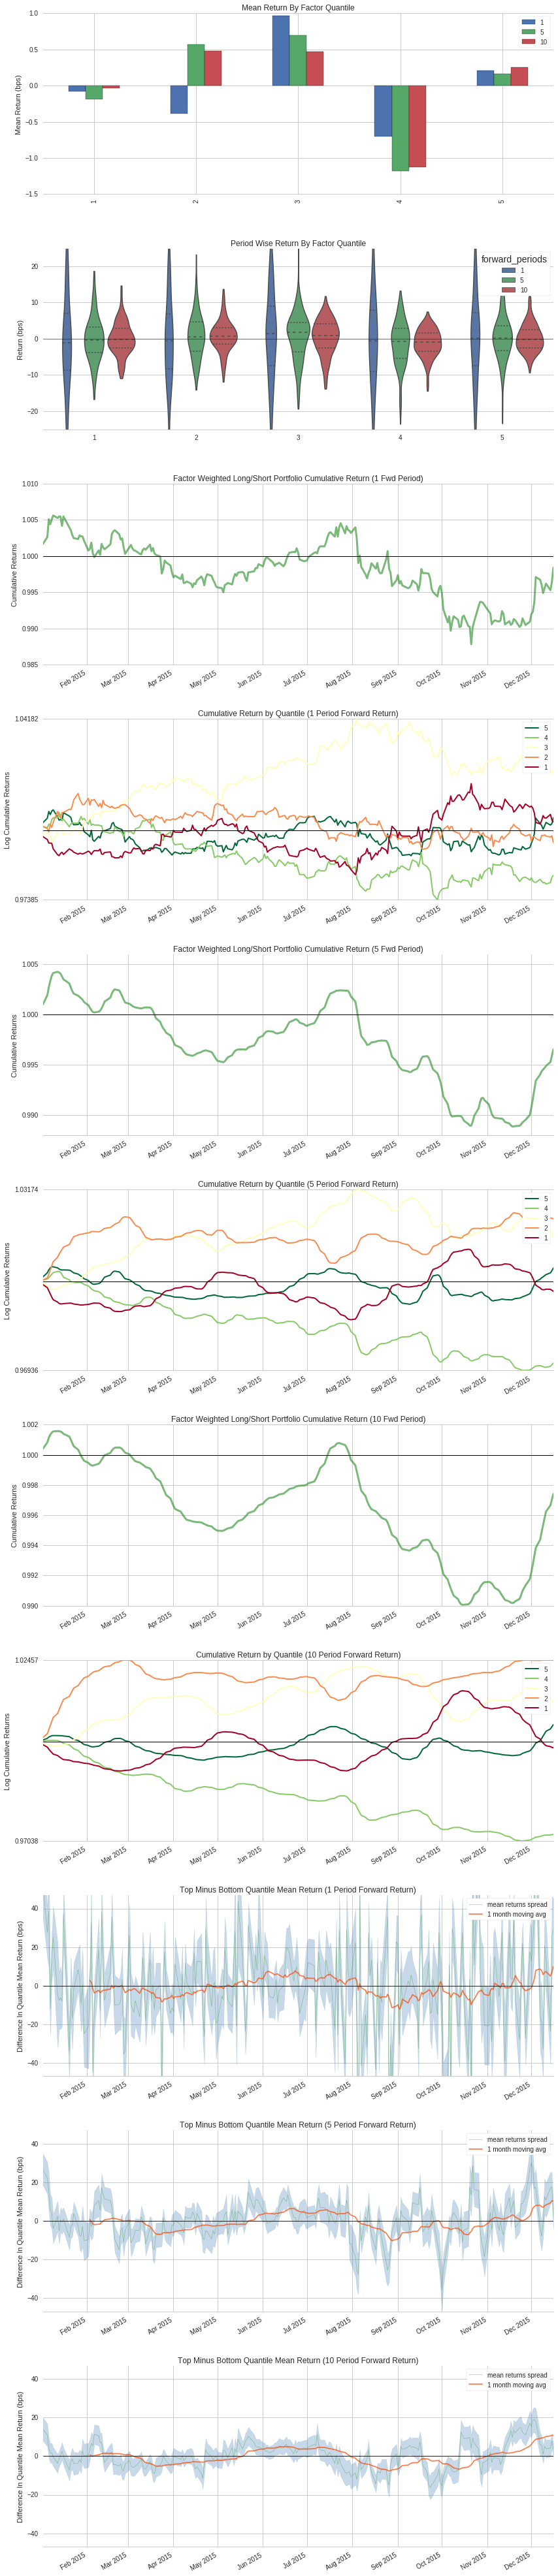

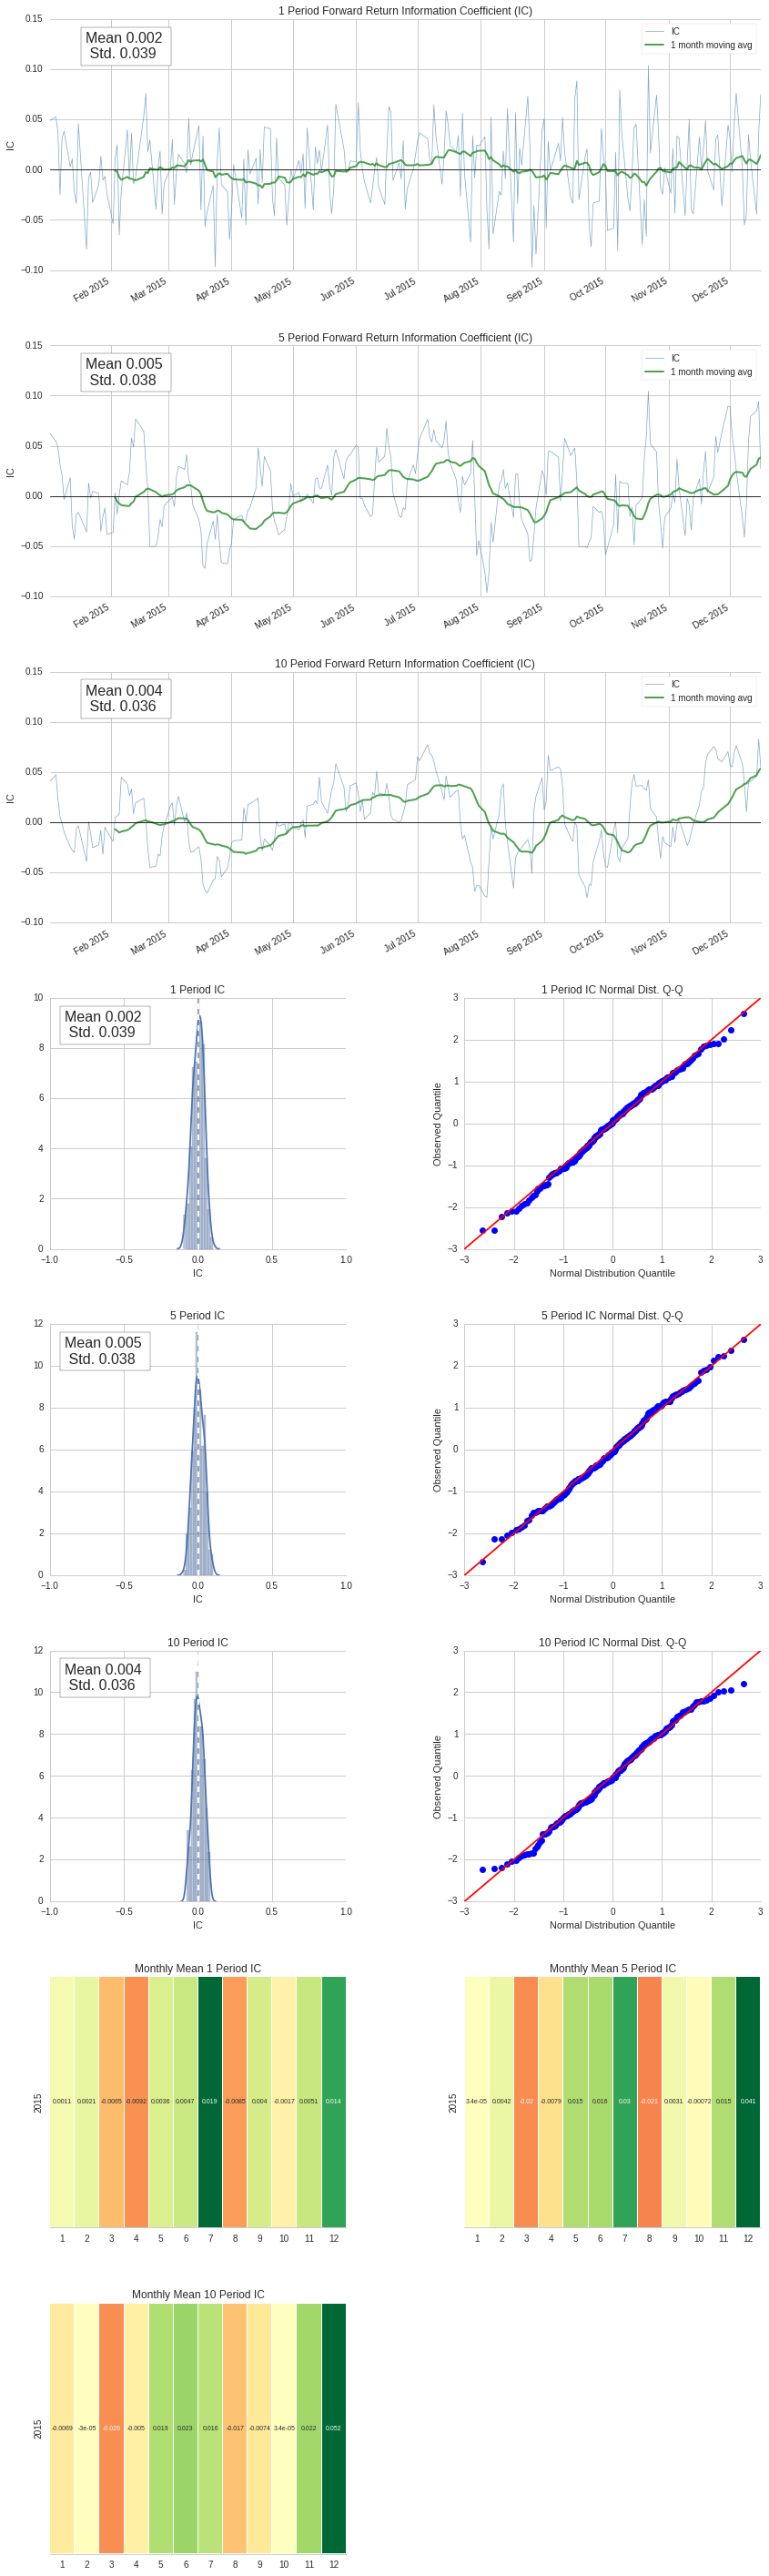

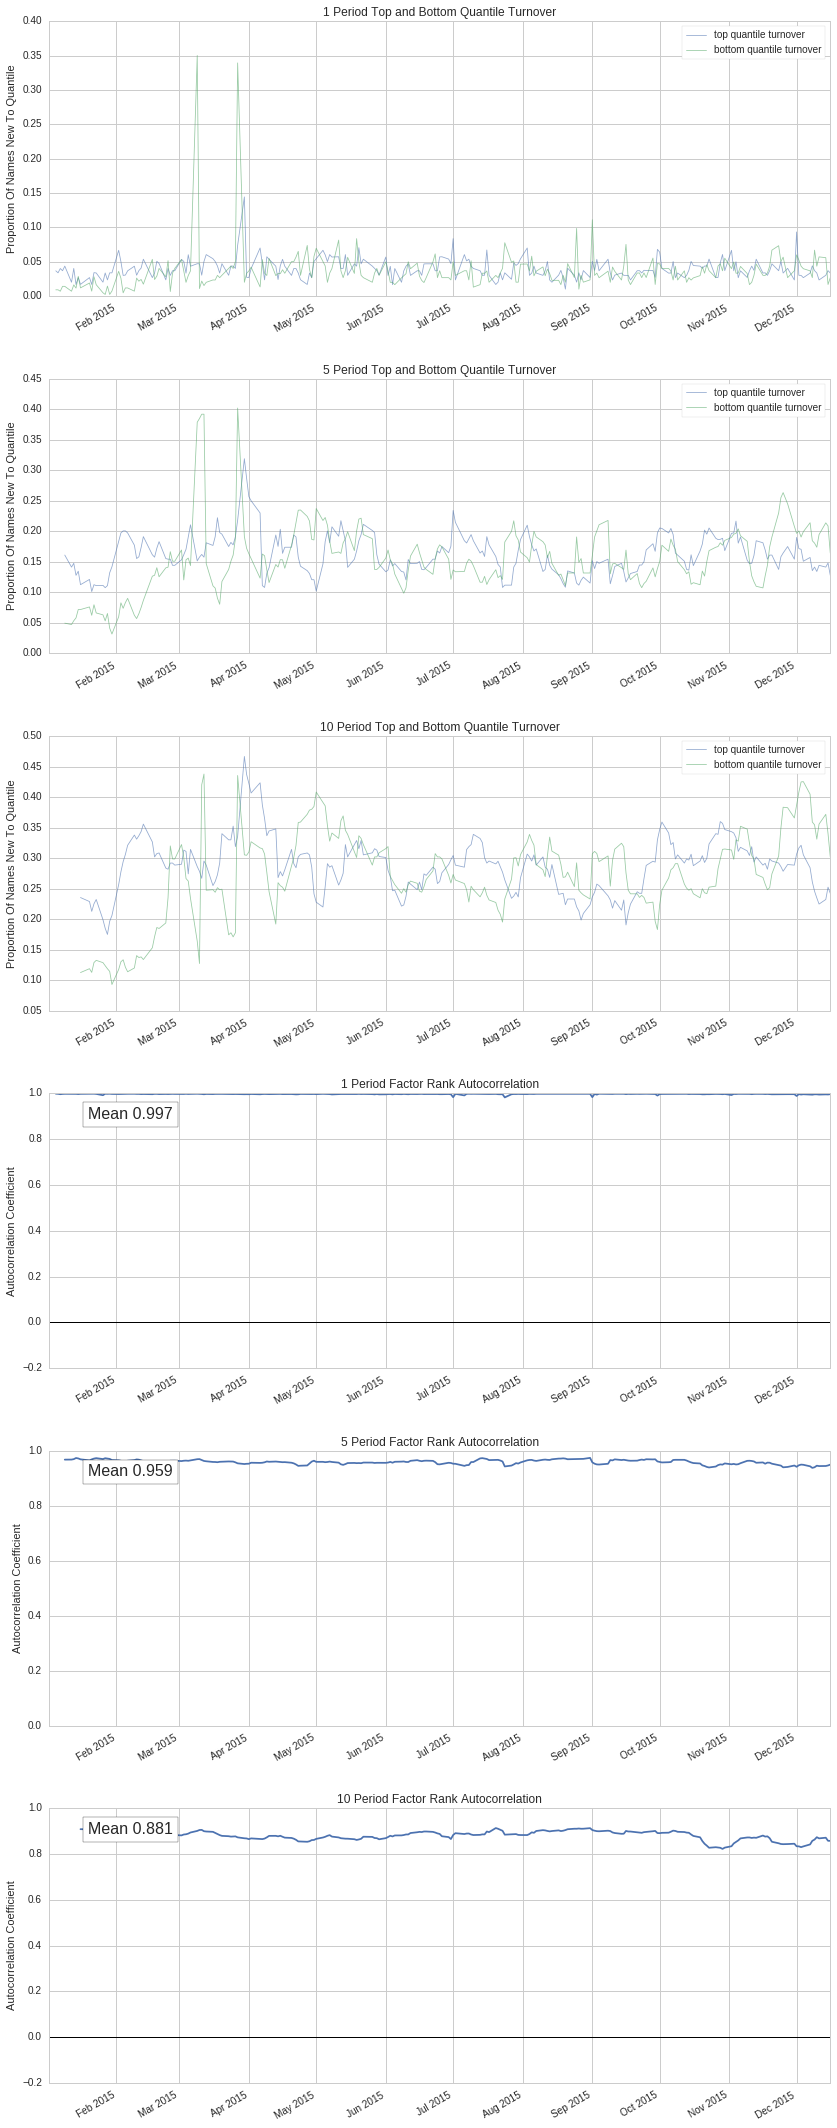

In [122]:
sma_20_factor_data = al.utils.get_clean_factor_and_forward_returns(
                                                            factor=sma_20_factor,
                                                            prices=prices,
                                                            groupby=sectors,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            periods=(1, 5, 10))

al.tears.create_full_tear_sheet(sma_20_factor_data)

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -3.000000 -1.000000 -1.751171  0.523249  76756  21.299043
2               -1.416667  0.250000 -0.877779  0.298421  67537  18.740860
3               -1.000000  1.613333  0.200782  0.528034  72040  19.990399
4                0.075758  2.800000  1.422121  0.522560  72063  19.996781
5                1.320000  6.000000  3.171873  0.987163  71977  19.972917

Returns Analysis


1      5      10
Ann. alpha                                     0.002  0.000  0.001
beta                                          -0.012 -0.012 -0.009
Mean Period Wise Return Top Quantile (bps)     0.114  0.462  2.486
Mean Period Wise Return Bottom Quantile (bps) -1.046 -4.380 -7.925
Mean Period Wise Spread (bps)                  1.018  0.877  0.973

Information Analysis


1      5      10
IC Mean      0.003  0.007  0.006
IC Std.      0.040  0.039  0.036
t-stat(IC)   1.072  2.723  2.700
p-value(IC)  0.285  0.007  0.007
IC Skew     -0.182  0.055  0.006
IC Kurtosis -0.397 -0.394 -0.325
Ann. IR      1.094  2.779  2.756

Turnover Analysis


1      5     10
Quantile 1 Mean Turnover   0.027  0.115  0.209
Quantile 2 Mean Turnover   0.061  0.250  0.404
Quantile 3 Mean Turnover   0.063  0.257  0.423
Quantile 4 Mean Turnover   0.067  0.260  0.419
Quantile 5 Mean Turnover   0.033  0.130  0.227

1      5     10
Mean Factor Rank Autocorrelation  0.998  0.976  0.927

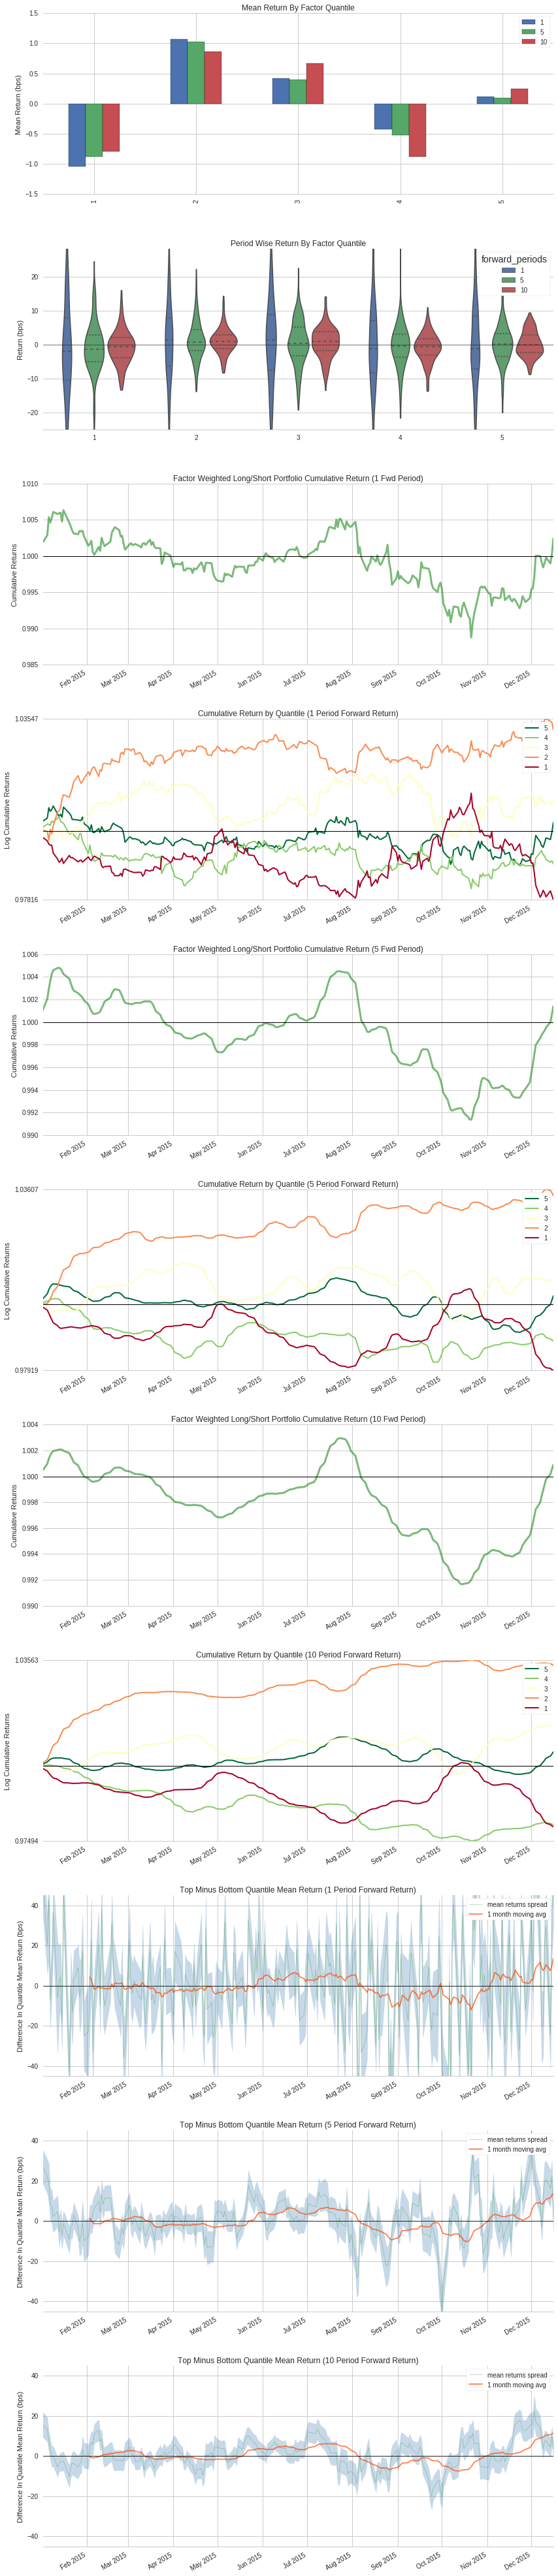

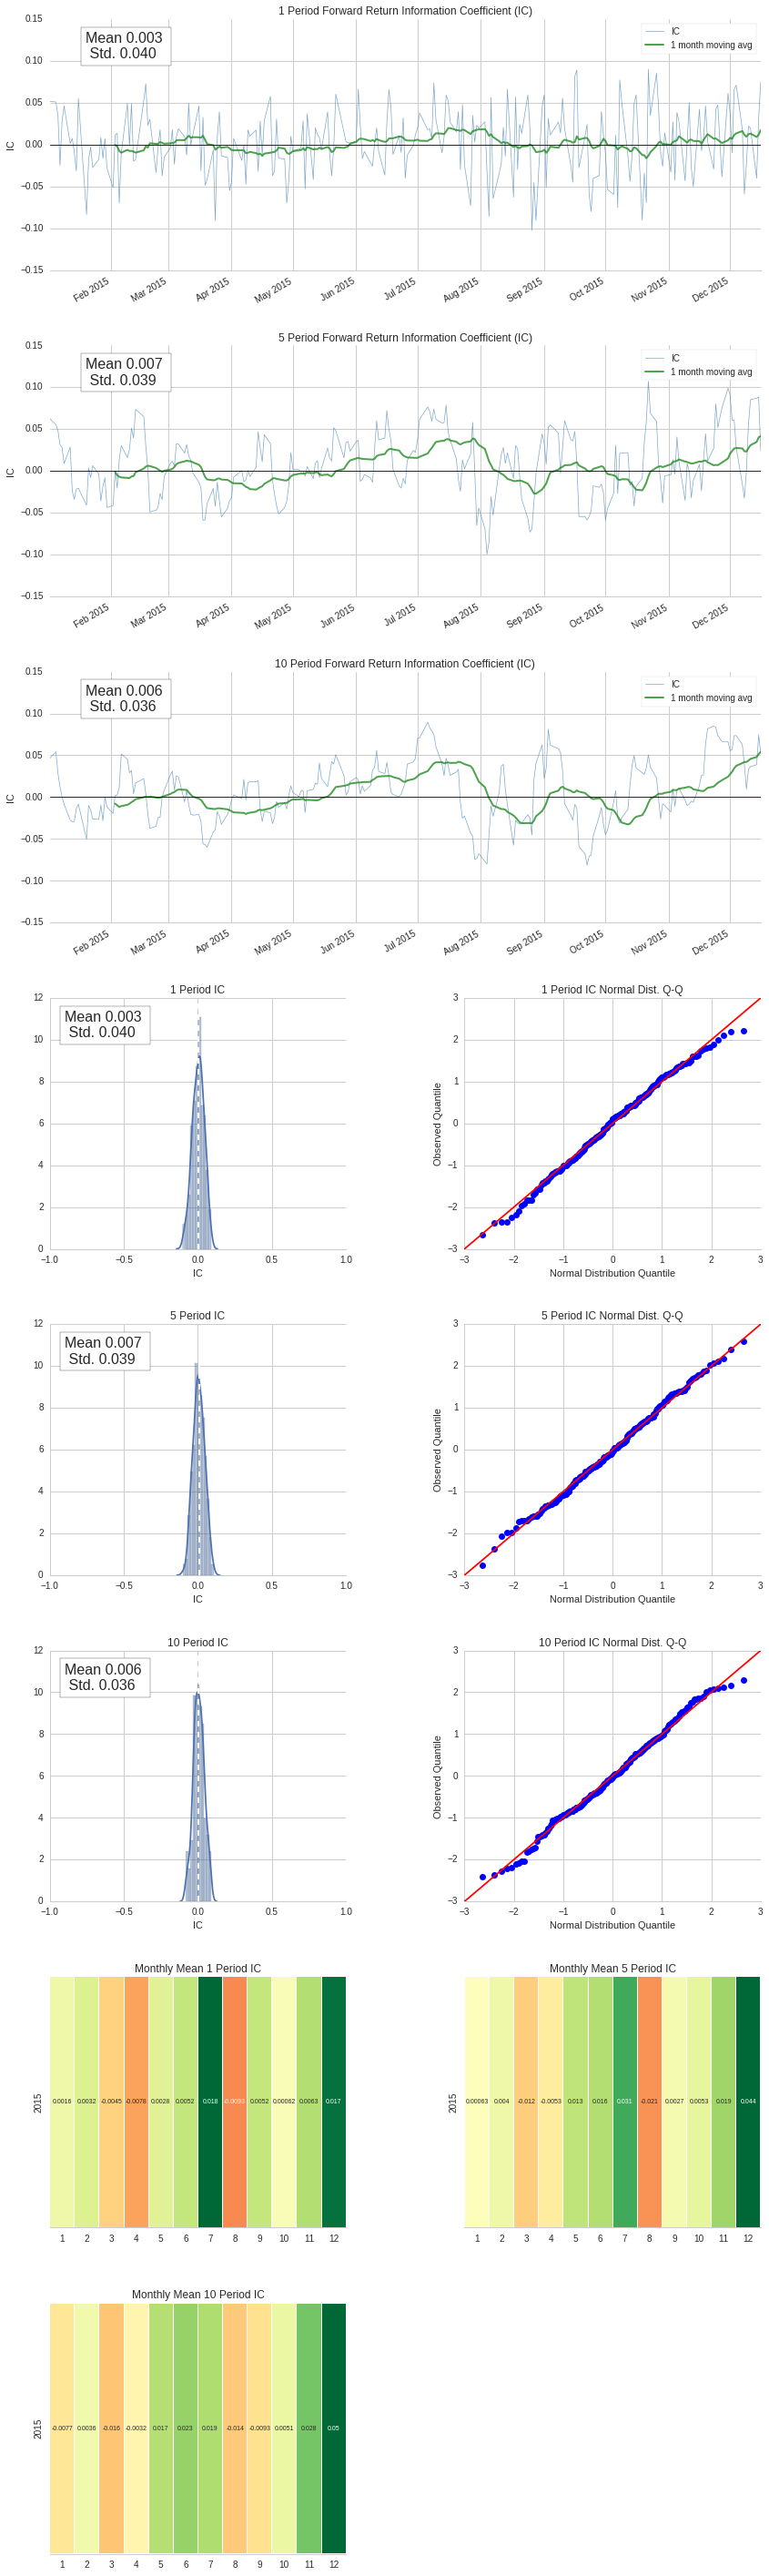

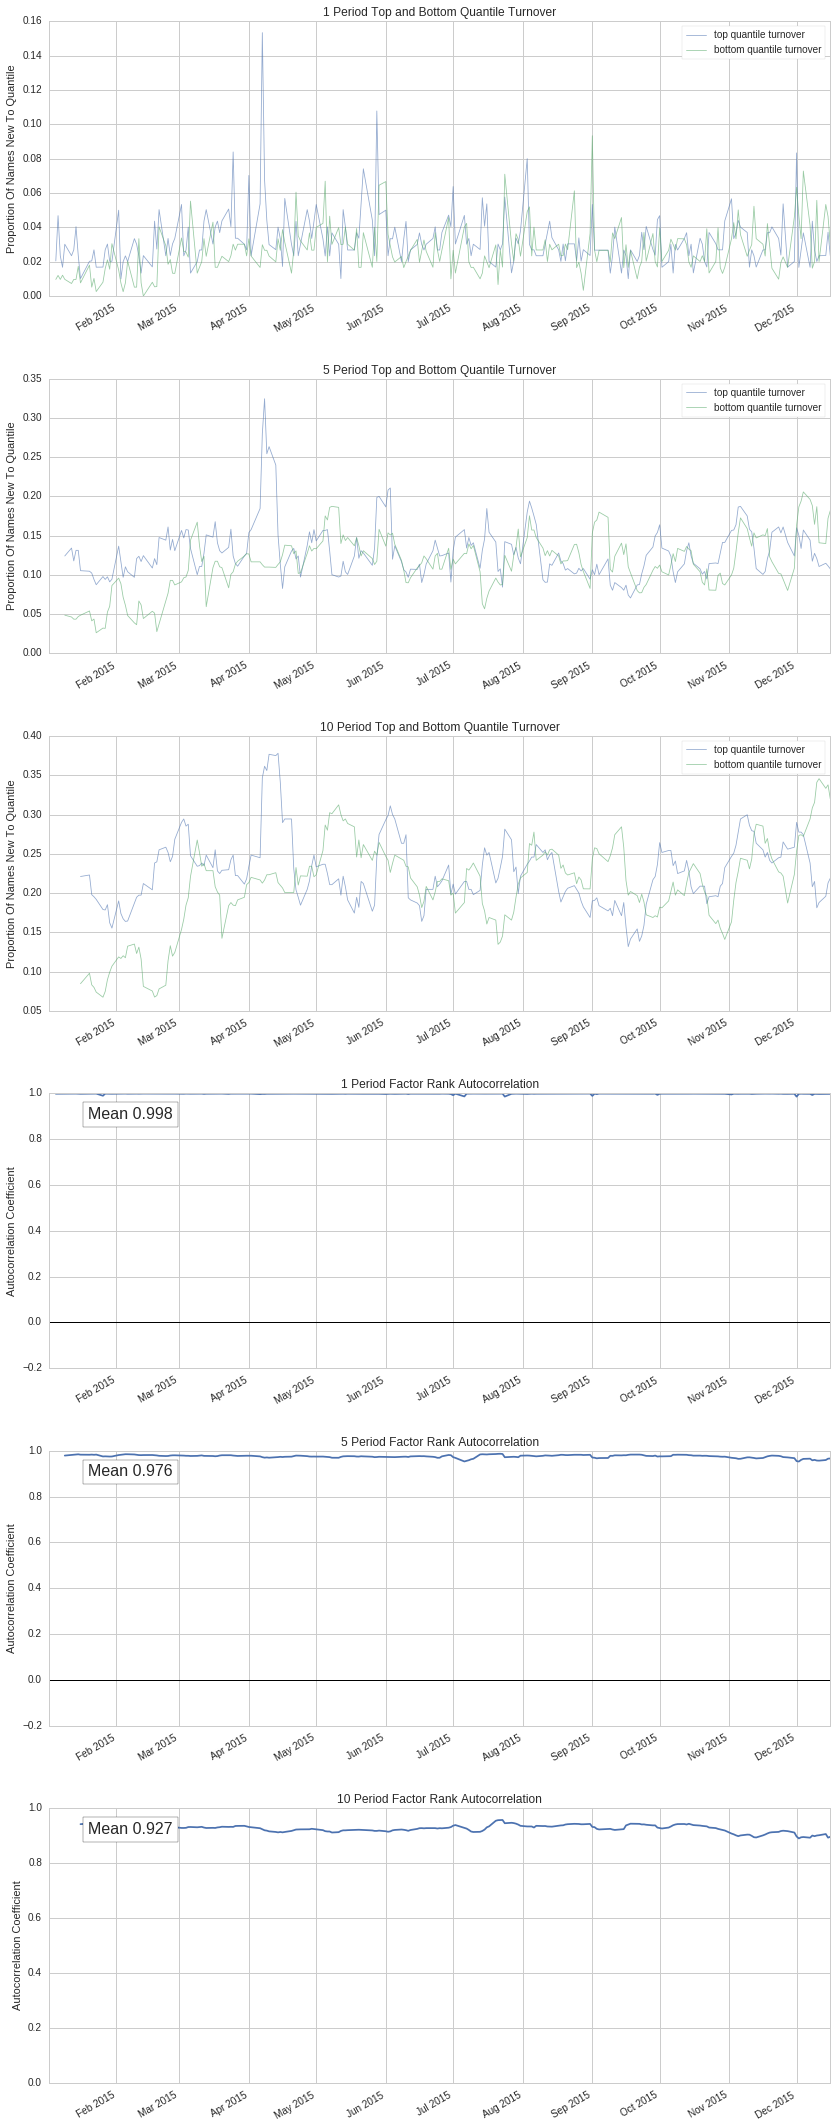

In [123]:
sma_30_factor_data = al.utils.get_clean_factor_and_forward_returns(
                                                            factor=sma_30_factor,
                                                            prices=prices,
                                                            groupby=sectors,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            periods=(1, 5, 10))

al.tears.create_full_tear_sheet(sma_30_factor_data)

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -3.000000 -1.000000 -1.648683  0.460701  75542  20.962170
2               -1.320000  0.374545 -0.770534  0.333964  68715  19.067744
3               -0.685714  1.622353  0.316989  0.489375  72030  19.987624
4                0.338182  2.700000  1.439699  0.499288  72026  19.986514
5                1.300000  6.000000  3.000353  0.885604  72060  19.995949

Returns Analysis


1      5      10
Ann. alpha                                     0.008  0.006  0.005
beta                                          -0.014 -0.015 -0.010
Mean Period Wise Return Top Quantile (bps)     0.339  0.515  2.026
Mean Period Wise Return Bottom Quantile (bps) -0.901 -4.324 -9.384
Mean Period Wise Spread (bps)                  1.200  0.948  1.135

Information Analysis


1      5      10
IC Mean      0.004  0.009  0.009
IC Std.      0.041  0.039  0.035
t-stat(IC)   1.508  3.473  3.791
p-value(IC)  0.133  0.001  0.000
IC Skew     -0.224 -0.057 -0.096
IC Kurtosis -0.526 -0.438 -0.446
Ann. IR      1.539  3.544  3.869

Turnover Analysis


1      5     10
Quantile 1 Mean Turnover   0.019  0.083  0.152
Quantile 2 Mean Turnover   0.042  0.180  0.321
Quantile 3 Mean Turnover   0.045  0.189  0.338
Quantile 4 Mean Turnover   0.047  0.189  0.333
Quantile 5 Mean Turnover   0.023  0.092  0.165

1      5     10
Mean Factor Rank Autocorrelation  0.999  0.987  0.962

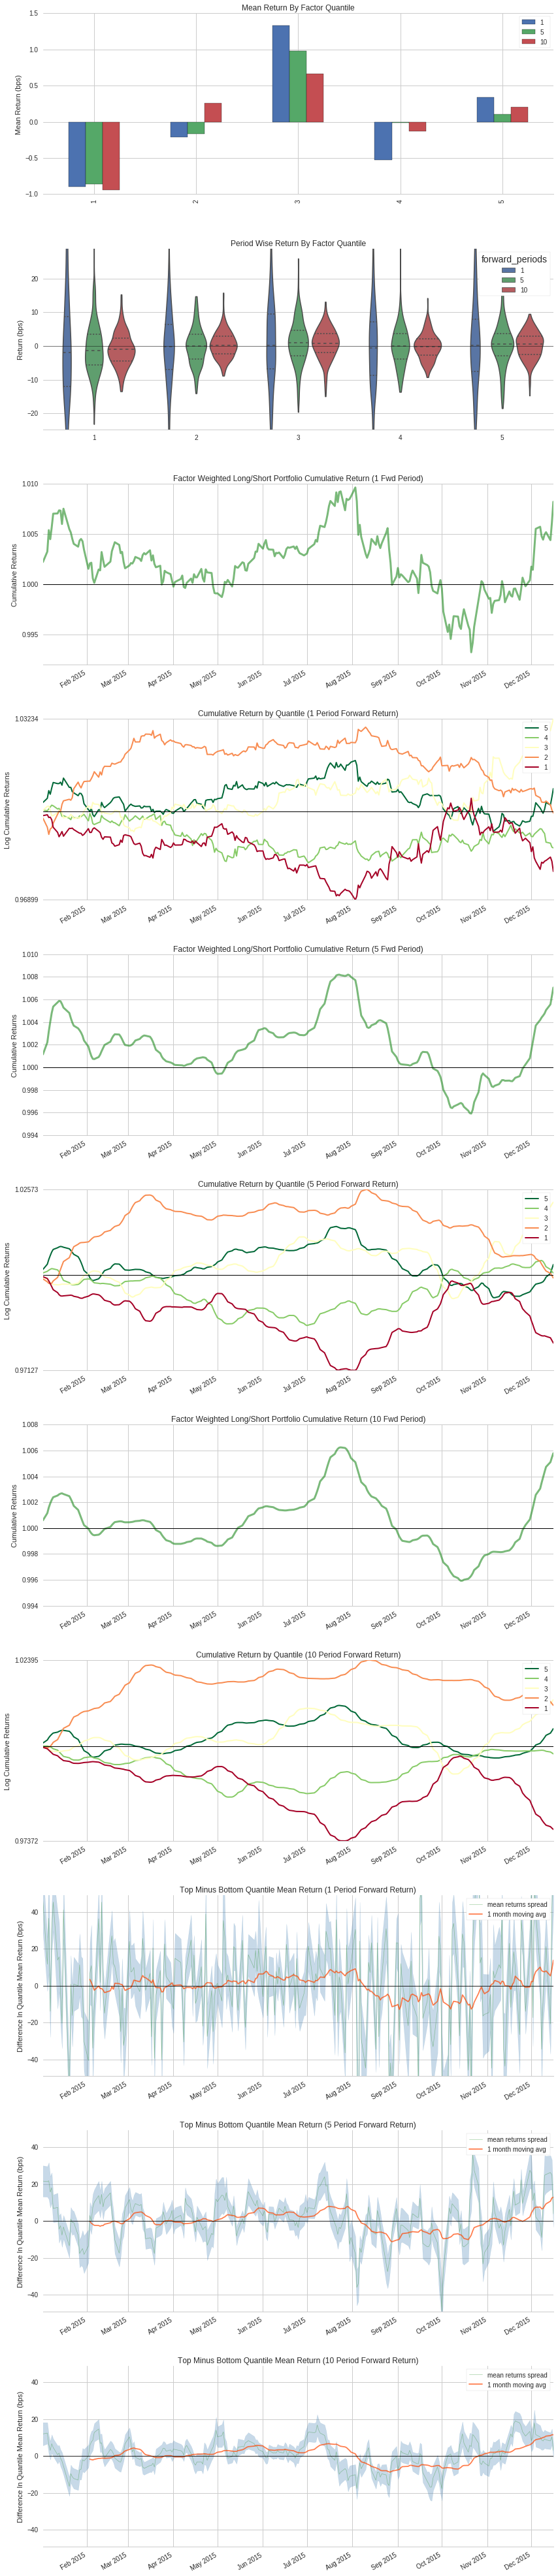

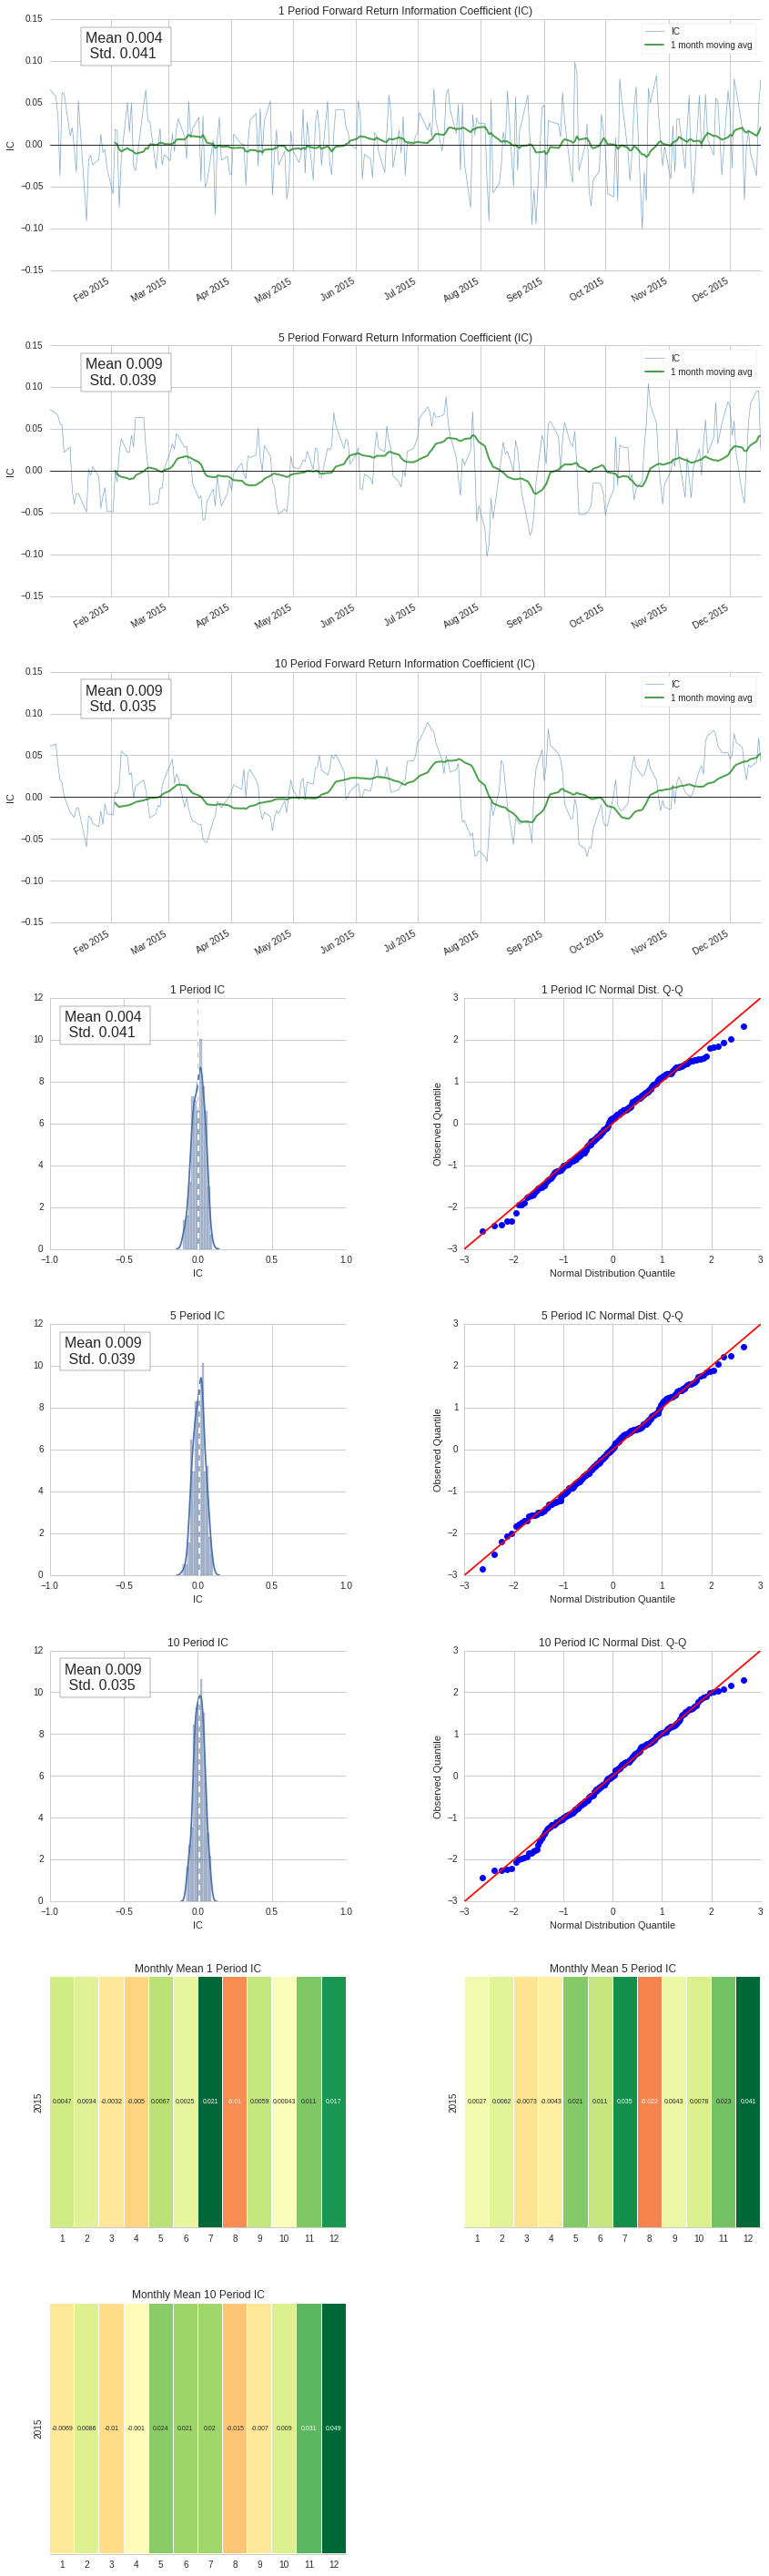

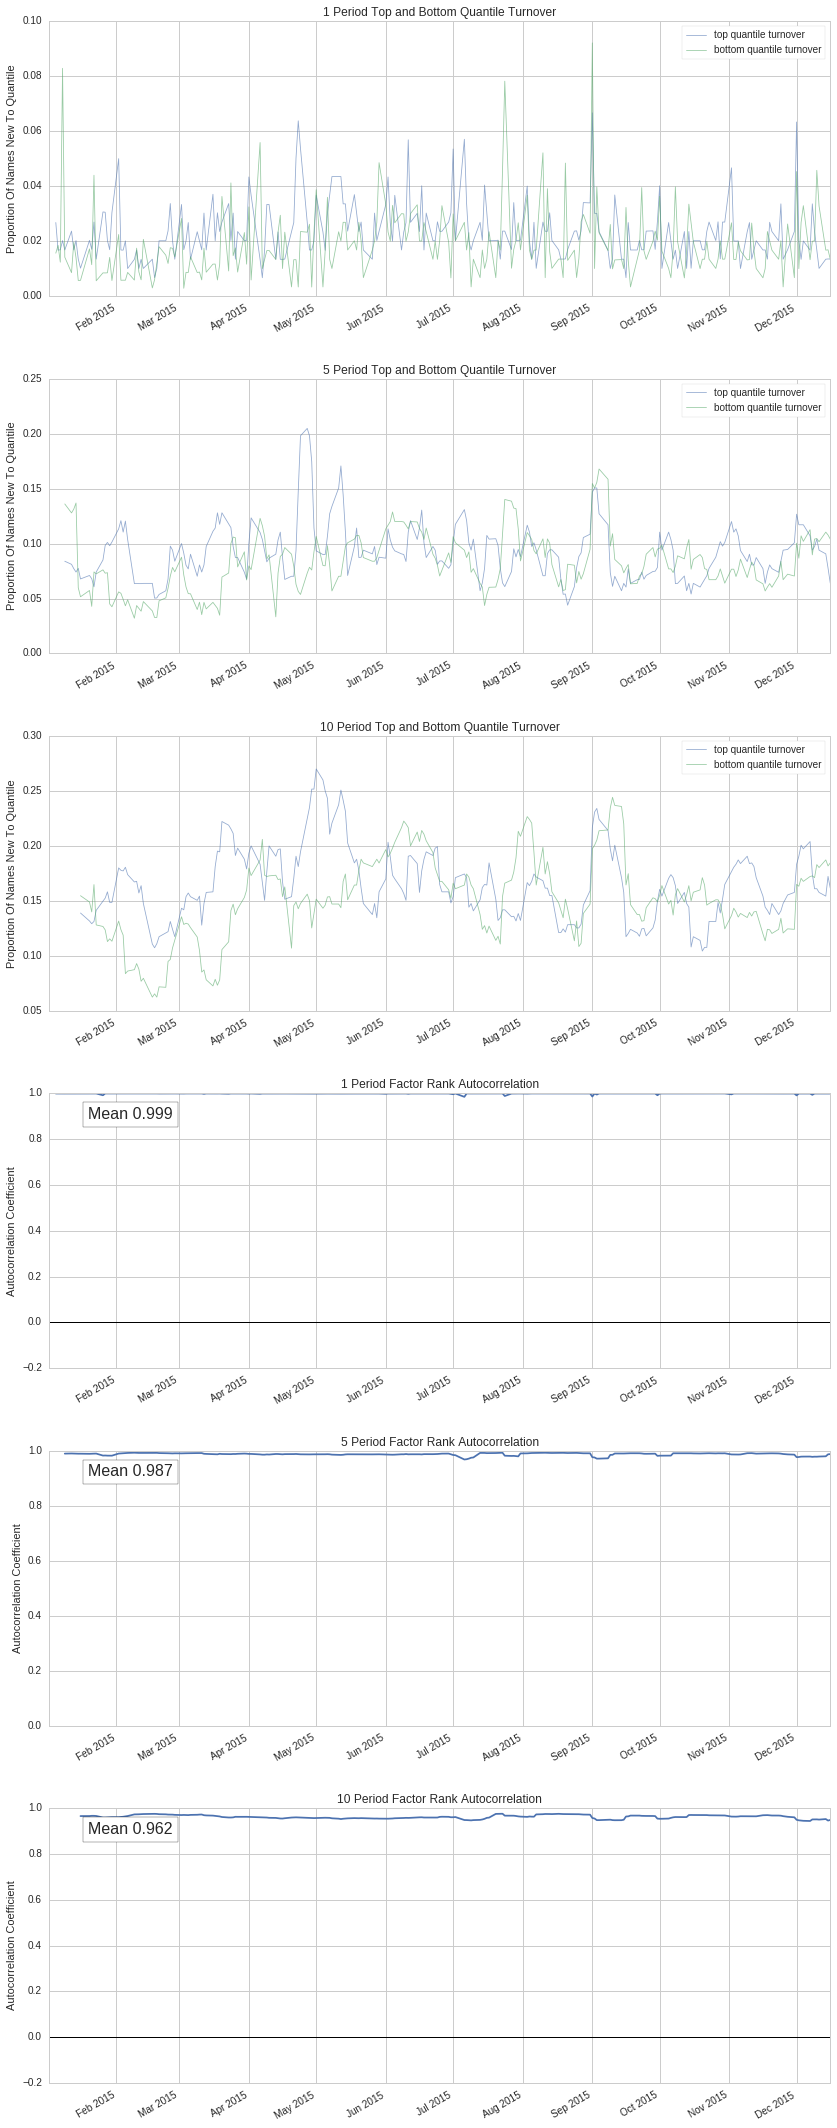

In [124]:
sma_50_factor_data = al.utils.get_clean_factor_and_forward_returns(
                                                            factor=sma_50_factor,
                                                            prices=prices,
                                                            groupby=sectors,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            periods=(1, 5, 10))
sma_50_factor_data.head()
al.tears.create_full_tear_sheet(sma_50_factor_data)

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -3.000000 -0.825000 -1.558496  0.401141  72725  20.180480
2               -1.330000  0.550000 -0.633595  0.366912  71521  19.846381
3               -0.488043  1.685714  0.417776  0.469458  72036  19.989289
4                0.454167  2.775000  1.456412  0.482140  72005  19.980687
5                1.425000  6.000000  2.851523  0.799360  72086  20.003163

Returns Analysis


1      5       10
Ann. alpha                                     0.011  0.009   0.008
beta                                          -0.014 -0.016  -0.013
Mean Period Wise Return Top Quantile (bps)     0.141 -0.398  -0.059
Mean Period Wise Return Bottom Quantile (bps) -1.326 -5.527 -10.649
Mean Period Wise Spread (bps)                  1.464  1.025   1.054

Information Analysis


1      5      10
IC Mean      0.004  0.009  0.008
IC Std.      0.041  0.040  0.037
t-stat(IC)   1.611  3.493  3.498
p-value(IC)  0.108  0.001  0.001
IC Skew     -0.208 -0.129 -0.029
IC Kurtosis -0.548 -0.542 -0.626
Ann. IR      1.644  3.565  3.569

Turnover Analysis


1      5     10
Quantile 1 Mean Turnover   0.014  0.058  0.109
Quantile 2 Mean Turnover   0.029  0.126  0.233
Quantile 3 Mean Turnover   0.034  0.142  0.263
Quantile 4 Mean Turnover   0.035  0.141  0.257
Quantile 5 Mean Turnover   0.017  0.071  0.128

1      5     10
Mean Factor Rank Autocorrelation  0.999  0.993  0.978

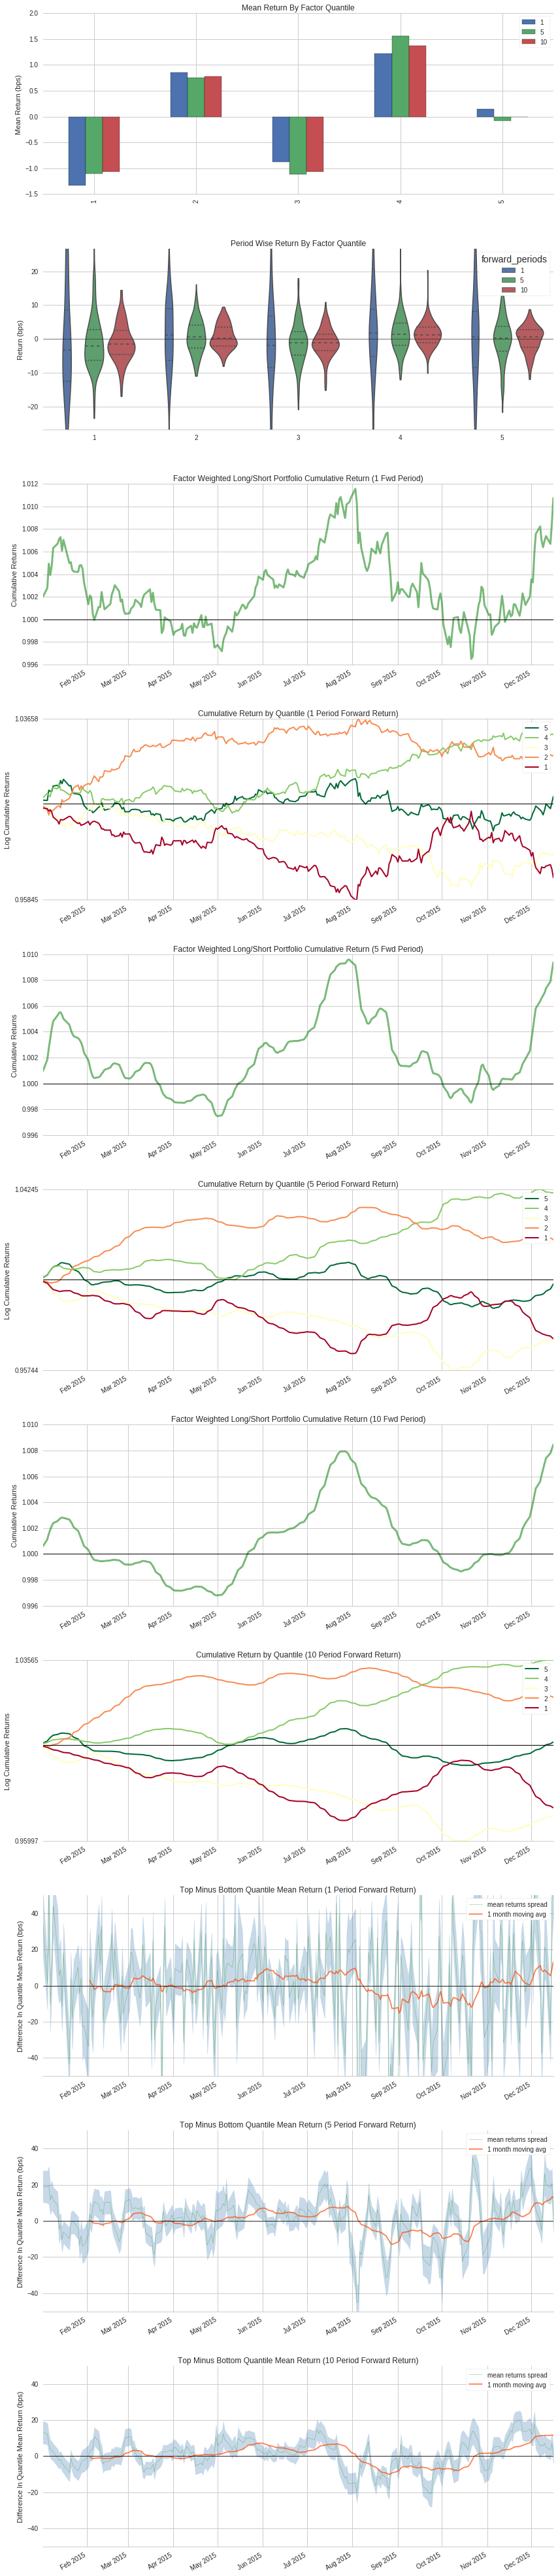

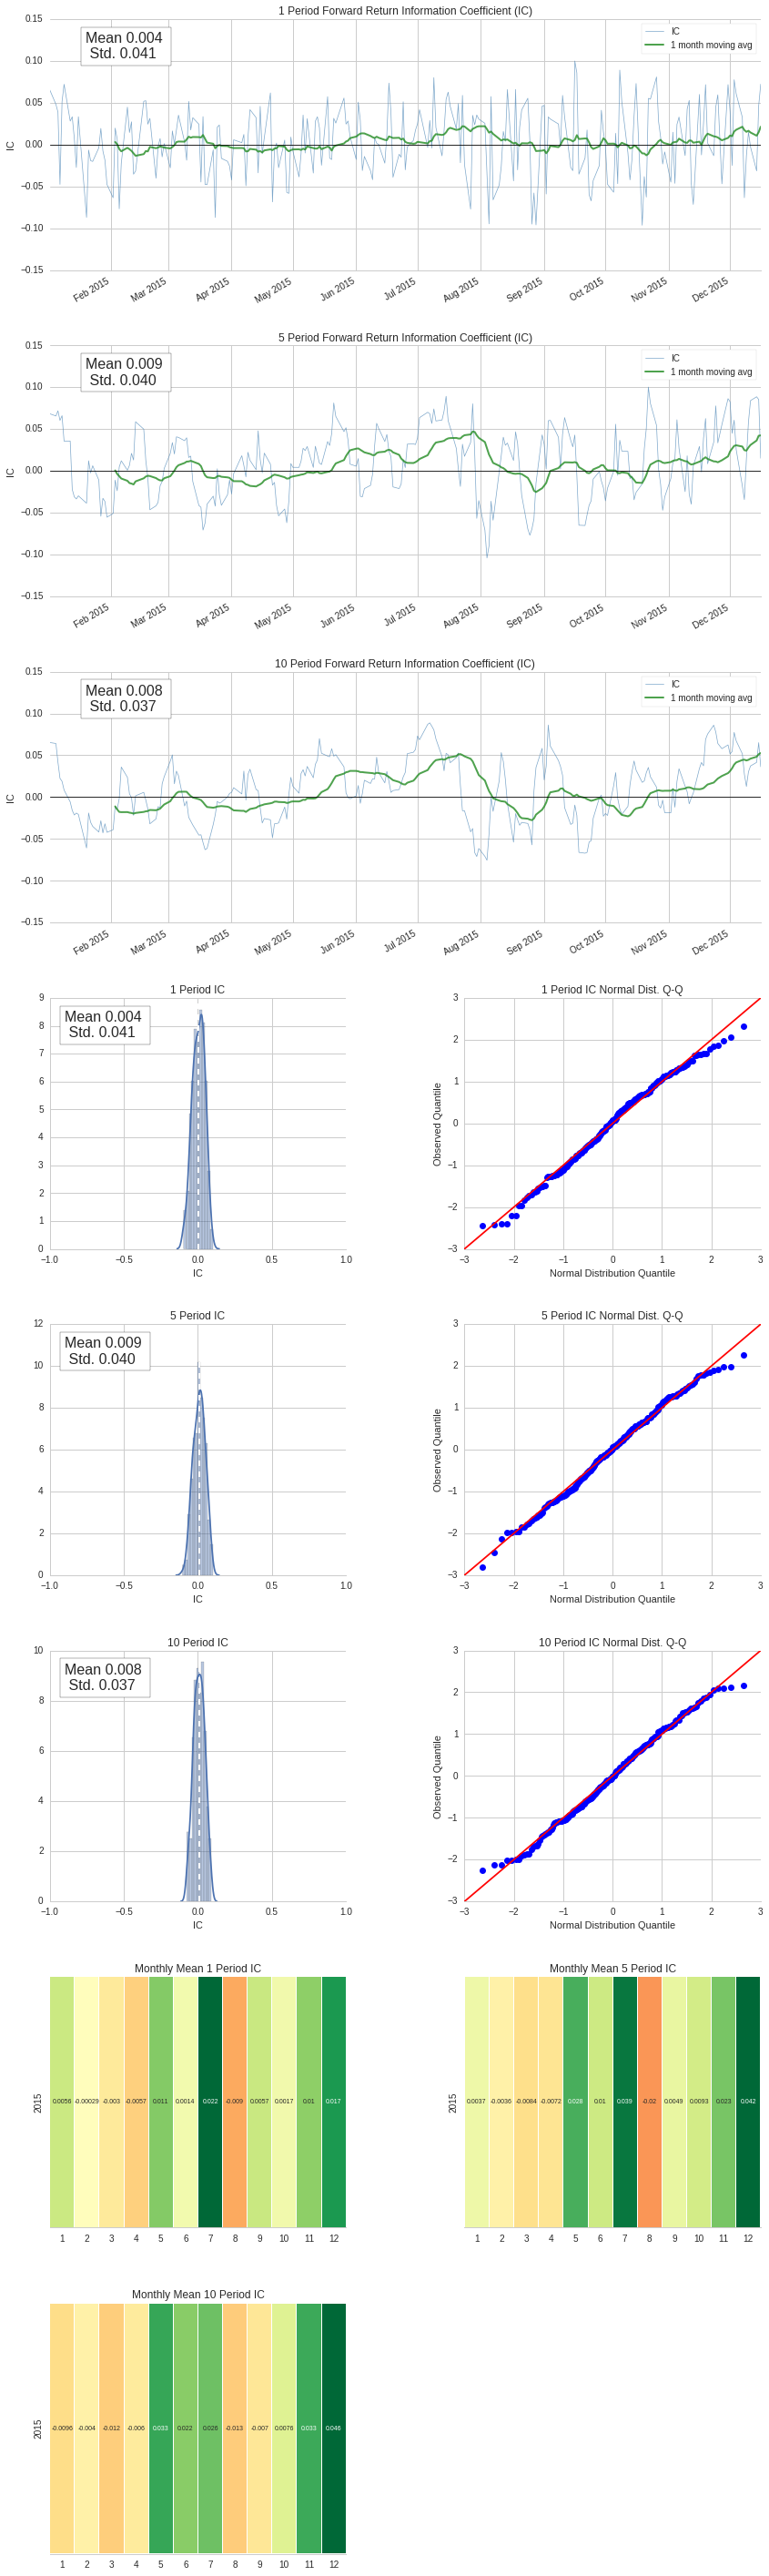

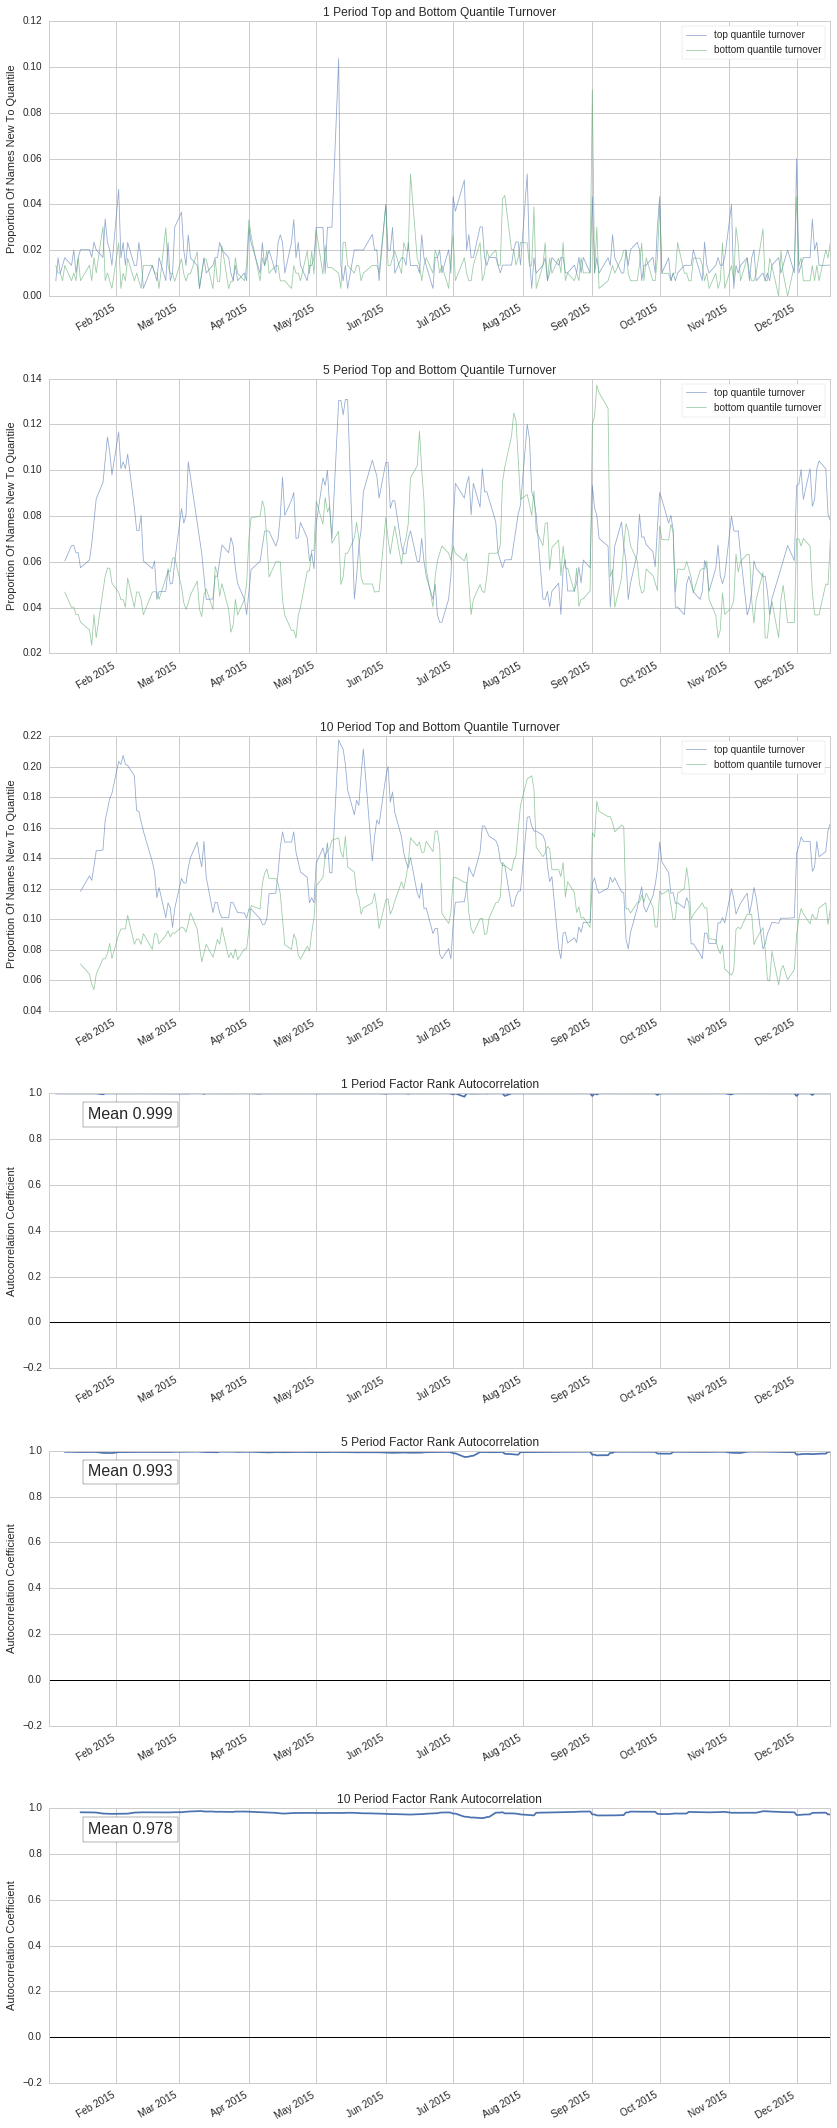

In [126]:
sma_80_factor_data = al.utils.get_clean_factor_and_forward_returns(
                                                            factor=sma_80_factor,
                                                            prices=prices,
                                                            groupby=sectors,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            periods=(1, 5, 10))
sma_80_factor_data.head()
al.tears.create_full_tear_sheet(sma_80_factor_data)